# Cleaning

In [11]:
# Importing
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

path = "../data/raw/houses_moreinfo.csv"

df = pd.read_csv(path)


In [12]:
df.head()

id            city  postal_code district       province     price  \
0  1882546        Wenduine         8420  Oostend  West Flanders  163000.0   
1  2784938   Heist-aan-Zee         8301   Brugge  West Flanders  108000.0   
2  4679861        Oostende         8400  Oostend  West Flanders  330000.0   
3  5650273  Dilsen-Stokkem         3650  Maaseik        Limburg  535000.0   
4  6349237       Corswarem         4257  Waremme          Liège       NaN   

     type_sale          subtype sale_type state_construction  ...  \
0        HOUSE           CHALET  FOR_SALE             AS_NEW  ...   
1        HOUSE         BUNGALOW  FOR_SALE             AS_NEW  ...   
2        HOUSE            HOUSE  FOR_SALE               GOOD  ...   
3        HOUSE  APARTMENT_BLOCK  FOR_SALE                NaN  ...   
4  HOUSE_GROUP      HOUSE_GROUP  FOR_SALE                NaN  ...   

   swimmingpool  has_balcony  has_terrace  has_attic  has_basement  \
0             0          NaN          NaN        NaN           NaN   
1             0          NaN          NaN        NaN           NaN   
2             0          NaN          1.0        NaN           NaN   
3             0          NaN          NaN        NaN           NaN   
4             0          NaN          NaN        NaN           NaN   

   construction_year  epc  heating  life_annuity  area_total  
0             2023.0  NaN      GAS             0       155.0  
1             2023.0  NaN      GAS             0       170.0  
2                NaN    B      NaN             0        65.0  
3             1988.0    B      GAS             0         0.0  
4                NaN  NaN      NaN             0         NaN  

[5 rows x 33 columns]

In [13]:
# Change name of places to lower
def format_name(x):
    return x.lower()

df["city"] = df.city.apply(format_name)
df["district"] = df.district.apply(format_name)
df["province"] = df.province.apply(format_name)

# Substitute 0 for Nan
df.replace(0, np.nan, inplace=True)


In [14]:
# Drop rows with life_annuity == 1
life_annuity = df.query("life_annuity == 1").index

df.drop(life_annuity, inplace=True)
df.shape

(44908, 33)

In [15]:
# Drop where price is NaN
df.dropna(subset=['price'], inplace=True)

In [16]:
# Drop useless columns
df.drop(['life_annuity', 'has_balcony', "sale_type", "type_sale", "furnished", "heating" ], axis=1, inplace=True)

In [17]:
# Drop subtypes that are not monoliving spaces
bad_columns = df["subtype"].isin(["CASTLE","APARTMENT_BLOCK", "MIXED_USE_BUILDING", "MANSION", "OTHER_PROPERTY", "MANOR_HOUSE"])
df_clean = df[~bad_columns]
# Drop empty living
df_clean.dropna(subset=['living_area'], inplace=True)
zero_rows = df_clean["living_area"] == 0 
df_clean = df_clean[~zero_rows]
# Drop empty total_area
df_clean.dropna(subset=['area_total'], inplace=True)
zero_rows1 = df_clean["area_total"] == 0
df_clean = df_clean[~zero_rows1]


df_clean.groupby("subtype").price.mean()

C:\Users\t_dei\AppData\Local\Temp\ipykernel_3640\3621434080.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.dropna(subset=['living_area'], inplace=True)


subtype
BUNGALOW                3.364770e+05
CHALET                  1.573134e+05
COUNTRY_COTTAGE         5.585352e+05
EXCEPTIONAL_PROPERTY    1.164985e+06
FARMHOUSE               7.224067e+05
HOUSE                   4.006107e+05
TOWN_HOUSE              3.763377e+05
VILLA                   9.495614e+05
Name: price, dtype: float64

In [78]:
# Exporting as a new CSV
# df_clean.to_csv("Cleaned_2.csv", sep=',', index=False, encoding='utf-8')

# Start exploring

In [18]:
df_clean.shape


(30554, 27)

In [19]:
# Missing values
percent_missing = df_clean.isnull().sum() * 100 / len(df)
percent_missing

id                     0.000000
city                   0.000000
postal_code            0.000000
district               0.000000
province               0.000000
price                  0.000000
subtype                0.000000
state_construction    18.255135
living_area            0.000000
terrace_area          51.475116
garden_area           48.508800
rooms                 49.613988
bedrooms               0.452645
bathrooms              6.256606
livingroom_surface    38.814852
kitchen_surface       41.498552
facades               13.606911
has_garden            43.587151
kitchen               28.217913
fireplace             56.265797
swimmingpool          67.632462
has_terrace           33.429070
has_attic             49.198107
has_basement          42.282064
construction_year     27.930702
epc                   12.602822
area_total             0.000000
dtype: float64

### Usefull functions

In [20]:
def IQR (column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    #quartiles = df[column].quantile([0.25, 0.75])
    iqr = Q3 - Q1
    lowerlimit = Q1 - 1.5*iqr
    upperlimit = Q3 + 1.5*iqr

    return lowerlimit, upperlimit

def thousants_point(x, n):
    return str('{:,}'.format(round(x), n).replace(',','.'))

### Usefull new columns

In [21]:
df_clean ["Price per Living Area"] = df_clean ["price"]/df_clean ["living_area"]
df_clean ["Price per Total Area"] = df_clean ["price"]/df_clean ["area_total"]
df_clean ["Outside area"] = df_clean["garden_area"] + df_clean["terrace_area"]


## Cleaning outliers

In [362]:
# Cleaning the price outliers via tukey IQR approach
lowerlimit, upperlimit  = IQR(df["price"])
no_outliers = df_clean[df_clean['price'].between(lowerlimit, upperlimit)]

# Cleaning total_area outliers
lowerlimit_tarea, upperlimit_tarea  = IQR(df["area_total"])
no_outliers = no_outliers[no_outliers['area_total'].between(lowerlimit_tarea, upperlimit_tarea)]

# Cleaning living_area outliers
lowerlimit_larea, upperlimit_larea  = IQR(df["living_area"])
no_outliers = no_outliers[no_outliers['living_area'].between(lowerlimit_larea, upperlimit_larea)]
mask_living = no_outliers['living_area']> 40
no_outliers = no_outliers[mask_living]

mask_total_area = no_outliers['area_total']> 40
no_outliers = no_outliers[mask_total_area]

## Graph number of properties per price

In [363]:

# Define variables to be plotted together with graph
no_outliers_q1 = no_outliers["price"].quantile(0.25)
no_outliers_q3 = no_outliers["price"].quantile(0.75)
average_price_no_outliers = no_outliers.price.mean()


# Sets up texts to be displayed with the above variables
text_average = "Avg € " + thousants_point(average_price_no_outliers,0)
text_q1 = "Q1 € " + thousants_point(no_outliers_q1 ,0)
text_q3 = "Q3 € " + thousants_point(no_outliers_q3,0)


In [364]:

# Starts setting up histogram of prices
fig = px.histogram(no_outliers, x="price", nbins=40, labels={'price': "Price"}) 
fig.update_layout(bargap=0.2)

# Vertical lines that are added
fig.add_vline(x=average_price_no_outliers, line_dash = 'dash', line_color = 'firebrick', annotation_text= text_average, annotation_position="top")
fig.add_vline(x=no_outliers_q1, line_dash = 'dash', line_color = 'green', annotation_text= text_q1, annotation_position="top left")
fig.add_vline(x=no_outliers_q3, line_dash = 'dash', line_color = 'green', annotation_text= text_q3, annotation_position="top right")

# Making it a bit more pretty and clean
fig.update_layout(
    title = "Pricing distribution", 
    title_font=dict(size=20,
                    color='#1F449C',
                    family='Arial'),
    title_x=0.1,  
)

# Display plot
fig.show()


## Graph number of houses per price/m2

In [365]:

# Subsetting dataframe for variables to be explored
price_area = no_outliers[["id", "price", "area_total", "living_area", "district", "subtype"]]


# Calculates the price/ m2
price_area["Price per Living Area"] = price_area["price"]/price_area["living_area"]

# Cleans data from outliers via Tukey IQR method
lowerlimit, upperlimit  = IQR(price_area["Price per Living Area"])
price_area = price_area[price_area["Price per Living Area"].between(lowerlimit, upperlimit)]

# Set up info to be added to plot (average) and its text
average_price_living_area = price_area["Price per Living Area"].mean()
text_average_living = "Avg € " + thousants_point(average_price_living_area,0) + "/m²"

# Starts setting up the histogram
fig = px.histogram(price_area, x="Price per Living Area", nbins = 50, title="Number of houses versus price per m²", labels={"Price per Living Area": "Price per area (€ / m²)"}) 
fig.add_vline(x=average_price_living_area, line_dash = 'dash', line_color = 'firebrick', annotation_text= text_average_living, annotation_position="top")
fig.update_layout(bargap=0.2)

# Displays the plot
fig.show()

C:\Users\t_dei\AppData\Local\Temp\ipykernel_3640\2282493576.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Graph scatter plot price per living area

In [366]:
fig = px.scatter(no_outliers, x="price", y="area_total",  labels = {"area_total" : "Total Área (m2)", "price": "Price (€)"},trendline="ols", trendline_color_override="red")
fig.update_traces(marker=dict(size=2.5),
                  selector=dict(mode='markers'))
fig.show()


## Living area per price

In [367]:

fig = px.scatter(no_outliers, x="price", y="living_area",  labels = {"living_area" : "Living Área (m2)", "price": "Price (€)"},trendline="ols", trendline_color_override="red")
fig.update_traces(marker=dict(size=2.5),
                  selector=dict(mode='markers'))
fig.show()

## Graph avg house price/m2 versus year and EPC

In [368]:
# Selecting only columns with EPC correctly inputed
mask_epc = no_outliers['epc'].isin(["A++", "A+", "A", "B", "C", "D", "E", "F", "G"])
compare_epc_mask= no_outliers[mask_epc]

# Group EPCS A
group_epc = {"A++": "As", "A+" : "As", "A" : "As"}
epc_grouped= compare_epc_mask.replace({"epc":group_epc})



# Grouping interesting variables per EPC type
compare_epc = epc_grouped.groupby('epc', as_index=False)[["living_area",'construction_year']].mean().round()

# Starts bar plot to compare EPC, average pricing and construction year
fig = px.bar(compare_epc, x='epc', y='living_area',  title="Avg house price and construction year per EPC", labels = {'Price per Living Area':'Avg House Price / living area (€/m2)', 'epc': "EPC", "construction_year": "Avg year construction"}, color_continuous_scale = 'Turbo')
fig.update_xaxes(categoryorder='array', categoryarray= ["As", 'B', 'C', 'D', 'E', 'F', 'G'])
fig.show()

In [369]:


# Filters for bigger districts
districts = ["antwerp", "halle-vilvoorde", "gent", "liège", "turnhout" , "leuven", "nivelles", "aalst", "kortrijk", "charleroi" ]

# Select columns to do the correlation
epc_grou_dist = epc_grouped[epc_grouped['district'].isin(districts)]

fig = px.box(epc_grouped, hover_data=["price"],  x="price", y="epc", title="Distribution of price per EPC", labels = {"epc": "EPC", "price":"Price (€)"}, color="epc")

fig.update_yaxes(categoryorder='array', categoryarray= ["G", "F","E","D","C","B","As"])
fig = fig.update_layout(showlegend=False)


fig.show()

In [370]:
count_epc = epc_grouped.groupby('epc', as_index=False).id.count()
count_epc.head()

epc    id
0  As  1736
1   B  2763
2   C  3750
3   D  3858
4   E  2950

In [371]:
def find_range (x):
    if x >= 600000:
        return "600k or over"
    elif x < 600000 and x>400000:
        return "400k to 600k"
    elif x<=400000 and x>200000:
        return "200k to 400k"
    else:
        return "200k or under"

stacked_price = epc_grouped[["epc", "price"]]
stacked_price["Price Range"] = stacked_price.price.apply(find_range)
stacked_price.head()

C:\Users\t_dei\AppData\Local\Temp\ipykernel_3640\1099897998.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



epc     price    Price Range
11   B  245000.0   200k to 400k
17   E  300000.0   200k to 400k
24   E  185000.0  200k or under
40   C  599000.0   400k to 600k
57   C  245000.0   200k to 400k

In [372]:
stacked_price.sort_values("Price Range")

# Starts setting up histogram of prices
fig = px.histogram(stacked_price, x="epc", labels={'epc': "EPC"}, color= "Price Range", barmode = "group",title= "Number of properties per EPC and price range" ,  category_orders={"Price Range": ["600k or over","400k to 600k","200k to 400k", "200k or under"  ]}) 
fig.update_layout(bargap=0.2)
fig.update_xaxes(categoryorder='array', categoryarray= ["As", "B","C","D","E","F","G"])


# Display plot
fig.show()

## Distribution of price per living area

In [373]:

def range_living(x):
    if x >= 400:
        return "400 sqm and over"
    elif x >= 300 and x<400:
        return "300sqm to 400 sqm"
    elif x >=200 and x < 300:
        return "200sqm to 300 sqm"
    elif x >=100 and x < 200:
        return "100sqm to 200 sqm"
    else:
        return "under 100sqm"
    

# Filters for bigger districts
districts = ["antwerp", "halle-vilvoorde", "gent", "liège", "turnhout" , "leuven", "nivelles", "aalst", "kortrijk", "charleroi" ]

# Select columns to do the correlation
living_grou_dist = no_outliers[no_outliers['district'].isin(districts)]
living_grou_dist["Range Living Área"] = living_grou_dist.living_area.apply(range_living)
living_grou_dist.head()



C:\Users\t_dei\AppData\Local\Temp\ipykernel_3640\1477405336.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



id        city  postal_code  district         province     price  \
15  7222190        geel         2440  turnhout          antwerp  335527.0   
17  7363164    nivelles         1400  nivelles  walloon brabant  300000.0   
30  8167076        lede         9340     aalst    east flanders  478000.0   
34  8247897  kortenaken         3470    leuven  flemish brabant  337873.0   
35  8247898  kortenaken         3470    leuven  flemish brabant  354934.0   

   subtype state_construction  living_area  terrace_area  ...  has_terrace  \
15   HOUSE                NaN        160.0           NaN  ...          NaN   
17   HOUSE               GOOD        255.0          50.0  ...          1.0   
30   HOUSE             AS_NEW        179.0           NaN  ...          NaN   
34   HOUSE             AS_NEW        138.0           NaN  ...          NaN   
35   HOUSE             AS_NEW        160.0           NaN  ...          NaN   

    has_attic  has_basement  construction_year  epc  area_total  \
15        NaN           NaN                NaN  NaN       431.0   
17        NaN           1.0                NaN    E       281.0   
30        NaN           NaN                NaN  NaN       394.0   
34        NaN           NaN                NaN  NaN      1253.0   
35        NaN           NaN                NaN  NaN      2009.0   

    Price per Living Area  Price per Total Area  Outside area  \
15            2097.043750            778.484919           NaN   
17            1176.470588           1067.615658           NaN   
30            2670.391061           1213.197970           NaN   
34            2448.355072            269.651237           NaN   
35            2218.337500            176.671976           NaN   

    Range Living Área  
15  100sqm to 200 sqm  
17  200sqm to 300 sqm  
30  100sqm to 200 sqm  
34  100sqm to 200 sqm  
35  100sqm to 200 sqm  

[5 rows x 31 columns]

In [374]:
fig = px.box(living_grou_dist,  x="price", y="Range Living Área", color="Range Living Área", labels = {"price": "Price", "Range Living Área": "Living Área (sqm)"})

fig.update_yaxes(categoryorder='array', categoryarray= ["under 100sqm", "100sqm to 200 sqm","200sqm to 300 sqm","300sqm to 400 sqm","400 sqm and over"])
fig = fig.update_layout(showlegend=False)


fig.show()

## Graph price/m2 per state of construction and year

In [375]:
# Selecting rows with valid data for construction state
type_state = ["AS_NEW","JUST_RENOVATED", "GOOD", "TO_BE_DONE_UP", "TO_RENOVATE", "TO_RESTORE"]
mask_state_construction = no_outliers['state_construction'].isin(type_state)
compare_state_construction= no_outliers[mask_epc]

# Taking the mean of pricing
compare_state_construction = compare_state_construction.groupby('state_construction', as_index=False)[['Price per Living Area','construction_year','living_area']].mean().round()


# Starts bar plot to compare State of Construction, average pricing and construction year
prettier_labels = {"AS_NEW": "As new","JUST_RENOVATED": "Just renovated", "GOOD": "Good", "TO_BE_DONE_UP": "To be done up", "TO_RENOVATE": "To renovate", "TO_RESTORE": "To restore", "construction_year": "Year", "state_construction" : "State Construction", "price": "Price in €"}
fig = px.bar(compare_state_construction, x='state_construction', y='Price per Living Area', color='construction_year', title="Avg house price, construction year per Construction State", labels = prettier_labels, color_continuous_scale = 'Bluered')
fig.update_xaxes(categoryorder='array', categoryarray= ['A++', 'A+', 'A', 'B', 'C', 'D', 'E', 'G'])
fig.show()


## Make qualitative data to be quantitative

In [376]:
# Designates a numeric scale for qualitative data
epc_sub= {"A++":8, "A+":7, "A":6,"B":5,"C":4,"D":3,"E":2,"F": 1,"G":0}
state_sub = {"AS_NEW":3, "JUST_RENOVATED":2, "GOOD":2, "TO_BE_DONE_UP":1, "TO_RENOVATE":1, "TO_RESTORE":1 }


# Replaces string values for the numeric scale created
correlation_var= no_outliers.replace({"epc":epc_sub, "state_construction": state_sub})
# Filters out rows that have invalid input that were not able to be substituted before
correlation_var = correlation_var[correlation_var['epc'].isin([0,1,2,3,4,5,6,7,8, np.nan])]
correlation_var = correlation_var[correlation_var["state_construction"].isin([0,1,2,3,4,5, np.nan])]

# Filters for bigger districts
districts = ["antwerp", "halle-vilvoorde", "gent", "liège", "turnhout" , "leuven", "nivelles", "aalst", "kortrijk", "charleroi" ]

# Select columns to do the correlation
correlation_var = correlation_var[correlation_var['district'].isin(districts)]

# Select only houses
correlation_var = correlation_var[correlation_var['subtype']== "HOUSE"]

# Correct names of columns before plotting to something prettier
correct_names = {"price": "Price", 
                "living_area": "Living Area", 
                "state_construction": "State Construction", 
                "construction_year":"Construction year", 
                "epc": "EPC",
                "fireplace": "Has Fireplace",
                "facades": "Number of façades",
                "swimmingpool": "Has swimmingpool",
                "kitchen": "Has equipped kitchen",
                "area_total": "Total surface",
                "rooms": "Number of rooms",
                "bedrooms":"Number bedrooms",
                "bathrooms": "Number bathrooms",
                "livingroom_surface": "Livingroom surface",
                "kitchen_surface":"Kitchen Surface"
                }
correlation_var.rename(columns= correct_names, inplace = True)

correlation_var.head()

C:\Users\t_dei\AppData\Local\Temp\ipykernel_3640\1659451129.py:7: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



id        city  postal_code  district         province     Price  \
15  7222190        geel         2440  turnhout          antwerp  335527.0   
17  7363164    nivelles         1400  nivelles  walloon brabant  300000.0   
30  8167076        lede         9340     aalst    east flanders  478000.0   
34  8247897  kortenaken         3470    leuven  flemish brabant  337873.0   
35  8247898  kortenaken         3470    leuven  flemish brabant  354934.0   

   subtype  State Construction  Living Area  terrace_area  ...  \
15   HOUSE                 NaN        160.0           NaN  ...   
17   HOUSE                 2.0        255.0          50.0  ...   
30   HOUSE                 3.0        179.0           NaN  ...   
34   HOUSE                 3.0        138.0           NaN  ...   
35   HOUSE                 3.0        160.0           NaN  ...   

    Has swimmingpool  has_terrace  has_attic  has_basement  Construction year  \
15               NaN          NaN        NaN           NaN                NaN   
17               NaN          1.0        NaN           1.0                NaN   
30               NaN          NaN        NaN           NaN                NaN   
34               NaN          NaN        NaN           NaN                NaN   
35               NaN          NaN        NaN           NaN                NaN   

    EPC  Total surface  Price per Living Area  Price per Total Area  \
15  NaN          431.0            2097.043750            778.484919   
17    2          281.0            1176.470588           1067.615658   
30  NaN          394.0            2670.391061           1213.197970   
34  NaN         1253.0            2448.355072            269.651237   
35  NaN         2009.0            2218.337500            176.671976   

    Outside area  
15           NaN  
17           NaN  
30           NaN  
34           NaN  
35           NaN  

[5 rows x 30 columns]

In [377]:

correlation1= correlation_var[["Price", "Total surface", "Living Area", "Number of façades", "Number of rooms", "Number bedrooms", "Number bathrooms", "Construction year",  "State Construction", "EPC" ]]
# Creates dataframe of the correlations
correlation_graph_1 = correlation1.corr()

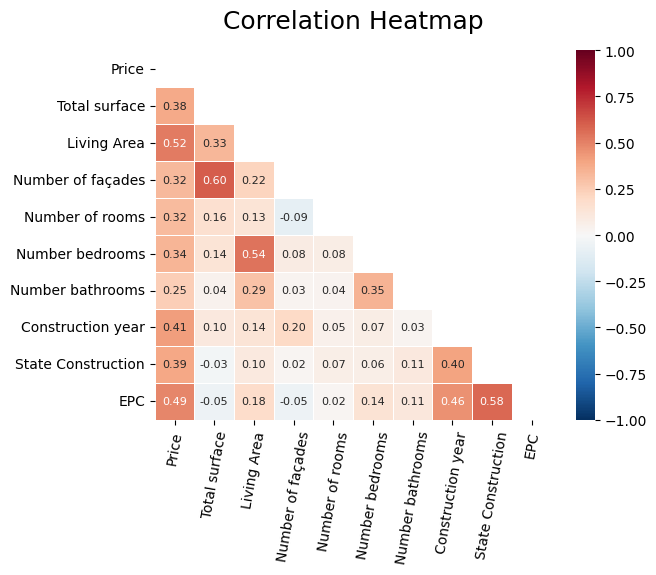

In [378]:

# Creates the heatmap of correlations in matrix form via seaborn
# Creates mask with numeric matrix that will exclude the upper half of the matrix
mask = np.triu(np.ones_like(correlation_graph_1 , dtype=bool))

# Creates the heatmap and plots it
heatmap = sns.heatmap(correlation_graph_1 , mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdBu_r', fmt=".2f", linewidth=.5, annot_kws = {"fontsize":8})
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
heatmap.tick_params(axis='x', rotation=80)



## Correlation of booleand data

In [379]:
# Select columns to do the correlation
correlation2= correlation_var[["Price", "Has Fireplace", "Has swimmingpool","Has equipped kitchen", "has_garden"]]
correlation2['Has Fireplace'] = correlation2['Has Fireplace'].fillna(0)
correlation2['Has swimmingpool'] = correlation2['Has swimmingpool'].fillna(0)
correlation2['Has equipped kitchen'] = correlation2['Has equipped kitchen'].fillna(0)
correlation2['has_garden'] = correlation2['has_garden'].fillna(0)

# Creates dataframe of the correlations
correlation_graph_2 = correlation2.corr(method ='pearson')

C:\Users\t_dei\AppData\Local\Temp\ipykernel_3640\1902993572.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\t_dei\AppData\Local\Temp\ipykernel_3640\1902993572.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\t_dei\AppData\Local\Temp\ipykernel_3640\1902993572.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

Text(0.5, 1.0, 'Correlation Heatmap')

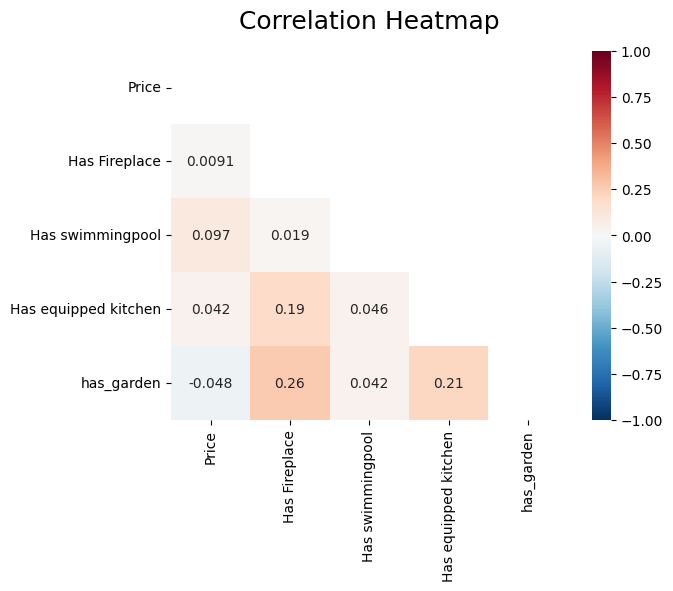

In [380]:
# Creates the heatmap of correlations in matrix form via seaborn
# Creates mask with numeric matrix that will exclude the upper half of the matrix
mask = np.triu(np.ones_like(correlation_graph_2  , dtype=bool))

# Creates the heatmap and plots it
heatmap = sns.heatmap(correlation_graph_2  , mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdBu_r')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

TO DO: explore boxplots, explore data per geographical location (price square meters per district, size of living per distric, volume per district), do scatter plot to see evolution of price per year (with a tendency curve). See put error margin in the average price graph per epc and construction state. Buble chart of price, volume (size bubble) and district).
Percentage of houses that are new, old, to renovate. Percentage of houses per any variable? ARE CHART X is PRICE, Y is VOLUME AND EACH LINE IS A DISTRICT?

House price per income per district? House availability per population? Correlation price number of rooms?
Age of building per district?

Number of bedrooms per district (box chart that piles up one over the other), also state of building, and epc. Pie charts of kitchen, fireplace etc (see if some municipality is more on those). Pie chart numher of bedrooms?

## JUNK CODE TO THINK LATER

In [263]:
epc_ant = epc_grouped [epc_grouped["district"] == "antwerp"]
epc_h = epc_grouped [epc_grouped["district"] == "halle-vilvoorde"]
epc_g = epc_grouped [epc_grouped["district"] == "gent"]
epc_li = epc_grouped [epc_grouped["district"] == "liège"]
epc_t = epc_grouped [epc_grouped["district"] == "turnhout"]
epc_l = epc_grouped [epc_grouped["district"] == "leuven"]
epc_n = epc_grouped [epc_grouped["district"] == "nivelles"]
epc_aal = epc_grouped [epc_grouped["district"] == "aalst"]
epc_k = epc_grouped [epc_grouped["district"] == "kortrijk"]
epc_c = epc_grouped [epc_grouped["district"] == "charleroi"]

fig1 = px.box(epc_ant, hover_data=["price"],  x="price", y="epc", title="Distribution of price per EPC", labels = {"epc": "EPC", "price":"Price (€)"}, color="epc")
fig2 = px.box(epc_h, hover_data=["price"],  x="price", y="epc", title="Distribution of price per EPC", labels = {"epc": "EPC", "price":"Price (€)"}, color="epc")
fig3 = px.box(epc_g, hover_data=["price"],  x="price", y="epc", title="Distribution of price per EPC", labels = {"epc": "EPC", "price":"Price (€)"}, color="epc")
fig4 = px.box(epc_li, hover_data=["price"],  x="price", y="epc", title="Distribution of price per EPC", labels = {"epc": "EPC", "price":"Price (€)"}, color="epc")
fig5 = px.box(epc_t, hover_data=["price"],  x="price", y="epc", title="Distribution of price per EPC", labels = {"epc": "EPC", "price":"Price (€)"}, color="epc")
fig6 = px.box(epc_l, hover_data=["price"],  x="price", y="epc", title="Distribution of price per EPC", labels = {"epc": "EPC", "price":"Price (€)"}, color="epc")
fig7 = px.box(epc_n, hover_data=["price"],  x="price", y="epc", title="Distribution of price per EPC", labels = {"epc": "EPC", "price":"Price (€)"}, color="epc")
fig8 = px.box(epc_aal, hover_data=["price"],  x="price", y="epc", title="Distribution of price per EPC", labels = {"epc": "EPC", "price":"Price (€)"}, color="epc")
fig9 = px.box(epc_k, hover_data=["price"],  x="price", y="epc", title="Distribution of price per EPC", labels = {"epc": "EPC", "price":"Price (€)"}, color="epc")
fig10 = px.box(epc_c, hover_data=["price"],  x="price", y="epc", title="Distribution of price per EPC", labels = {"epc": "EPC", "price":"Price (€)"}, color="epc")


In [282]:
fit = fig1

fit.update_yaxes(categoryorder='array', categoryarray= ["G", "F","E","D","C","B","As"])
fit = fit.update_layout(showlegend=False)
fit.show()